In [16]:
from fairseq import checkpoint_utils
import torch
hubert,_,_ = checkpoint_utils.load_model_ensemble_and_task(
    ["./hubert_base.pt"],
    suffix="",
)
hubert_model = hubert[0]
hubert_model = hubert_model.half()
hubert_model.eval()

# Create a Adapter model
class HuberAdapter(torch.nn.Module):
    def __init__(self, model):
        super(HuberAdapter, self).__init__()
        self.model = model
    def forward(self,feats):
        # inputs = {
        #     "source": feats,
        #     "padding_mask": padding_mask,
        #     # "padding_mask": None,
        #     "output_layer": 12
        # }
        # return self.model.extract_features(**inputs)
        return self.model(
            source = feats,
            output_layer = 12,
            features_only = True,
            mask = False
        )['x']

# Loading presaved feats and padding mask
feats = torch.load("./feats.pt")
padding_mask = torch.load("./padding_mask.pt")

2025-02-20 15:47:21 | INFO | fairseq.tasks.hubert_pretraining | current directory is /root/hubert
2025-02-20 15:47:21 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': 'metadata', 'fine_tuning': False, 'labels': ['km'], 'label_dir': 'label', 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2025-02-20 15:47:21 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout': 0.1, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.05, 'dropout_input': 0.1, 'dropout_features': 0.1, 'final_dim': 256,

In [17]:
adapter = HuberAdapter(hubert_model.cuda())

In [18]:
output = adapter(feats)

In [19]:
output[0].shape

torch.Size([100, 768])

In [20]:
output[1].shape

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [21]:
output[0]

tensor([[-0.1185, -0.0121, -0.1050,  ..., -0.0261,  0.1202, -0.0280],
        [-0.2391, -0.1191, -0.3018,  ..., -0.2734,  0.0823,  0.1033],
        [-0.1469, -0.0125, -0.2268,  ..., -0.2830, -0.0357,  0.0516],
        ...,
        [-0.0829,  0.2034, -0.3240,  ..., -0.0253,  0.3257,  0.0418],
        [-0.1323,  0.2222, -0.0968,  ...,  0.1378,  0.3203,  0.1581],
        [ 0.0549,  0.0267, -0.1801,  ..., -0.0232, -0.0334, -0.1389]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)

In [9]:
!pip install onnx onnxruntime-gpu

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
  Using cached https://repo.huaweicloud.com/repository/pypi/packages/dd/5b/c4f95dbe652d14aeba9afaceb177e9ffc48ac3c03048dd3f872f26f07e34/onnx-1.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 9.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 33.1 MB/s eta 0:00:00


Before runnning exportation code,i;ve modified fairseq/models/wav2vec/utils.py with below code:
```python
def pad_to_multiple(x, multiple, dim=-1, value=0):
    # Inspired from https://github.com/lucidrains/local-attention/blob/master/local_attention/local_attention.py#L41
    if x is None:
        return None, 0
    tsz = x.size(dim)
    m = tsz / multiple
    remainder = math.ceil(m) * multiple - tsz
    m = float(m) # => If without this,will raise `Tensor object has no attribute is_integer()`
    if m.is_integer():
        return x, 0
    pad_offset = (0,) * (-1 - dim) * 2

    return F.pad(x, (*pad_offset, 0, remainder), value=value), remainder
```

In [23]:
torch.onnx.export(
    adapter.cuda(),
    (feats.cuda()),
    "hubert.onnx",
    input_names=["feats",],
    output_names=["logits",],
    dynamic_axes={
        "feats": {0: "seq"},
        # "padding_mask": {0: "seq"},
    },
    opset_version=14,
    do_constant_folding=True,
)

/root/miniconda3/lib/python3.10/site-packages/fairseq/models/wav2vec/utils.py:16: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  remainder = math.ceil(m) * multiple - tsz
/root/miniconda3/lib/python3.10/site-packages/fairseq/models/wav2vec/utils.py:17: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if float(m).is_integer():
/root/miniconda3/lib/python3.10/site-packages/fairseq/modules/multihead_attention.py:507: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so thi

In [24]:
# 读取ONNX
import onnxruntime as ort

model = ort.InferenceSession("./hubert.onnx",providers = ["CUDAExecutionProvider"])

model

2025-02-20 15:47:59.288665863 [E:onnxruntime:Default, provider_bridge_ort.cc:1862 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1539 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcudnn.so.9: cannot open shared object file: No such file or directory

2025-02-20 15:47:59.288687537 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:993 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.


In [26]:
r = model.run(
    ["logits",],
    {
        "feats": feats.cpu().numpy(),
        # "padding_mask": padding_mask.cpu().numpy()
    }
)[0]

In [29]:
import numpy as np

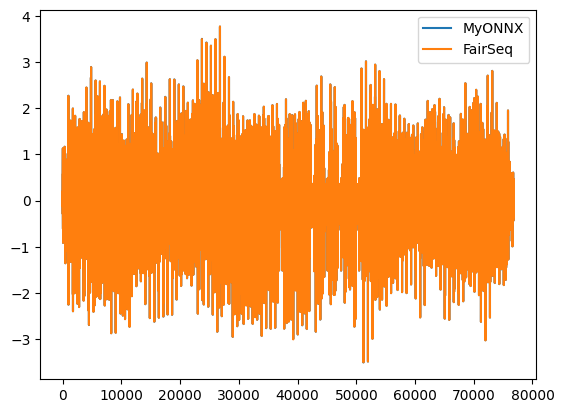

In [31]:
import matplotlib.pyplot as plt
plt.plot(np.array(r.flatten()),label="MyONNX")
plt.plot(output[0].flatten().cpu().detach().numpy(),label="FairSeq")
plt.legend()
plt.savefig("./output.png",dpi=300)
plt.show()